# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_091  Q5T848            17.133
Sample_056  H0YDE5            18.482
Sample_112  Q9UGM5;Q9UGM5-2   17.060
Sample_207  P00915            14.274
Sample_008  P02679            20.629
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_033  P05121           13.710
Sample_158  P00491           18.018
Sample_025  Q6P9A2           14.696
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.139
            A0A075B6Q5                 13.956
            A0A075B6R2                 12.398
            A0A075B6S5                 12.659
            A0A087WSY4                 12.311
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.282
            Q9UI40;Q9UI40-2            13.473
            Q9UIW2                     12.505
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.910
            Q9UP79                     11.529
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.759,15.050,16.842,19.863,15.854,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.713,19.067,...,15.528,15.576,13.866,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.834,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.845,17.705,17.039,15.452,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.762,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.732,15.345,17.084,18.708,14.249,19.433,11.517,10.629
Sample_207,15.739,16.877,15.469,16.898,13.353,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.139,...,16.012,15.178,12.889,15.050,16.842,19.863,12.711,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.096,19.067,16.188,...,15.528,15.576,12.445,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.085,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.427,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.653,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.266,15.345,17.084,18.708,14.249,19.433,13.090,13.346
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 376.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.13it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.99it/s]

100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.07it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.22it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.60it/s]

100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.60it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.46it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.88it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.95it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.77it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.37it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.74it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.79it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.25it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.01it/s]

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.01it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.56it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.45it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  2.73it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.43it/s]

 30%|███       | 3/10 [00:00<00:01,  4.56it/s]

 40%|████      | 4/10 [00:00<00:01,  4.09it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.48it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.28it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.36it/s]

100%|██████████| 10/10 [00:03<00:00,  2.12it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.67it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.03it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.62it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.54it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.26it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.31it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.39it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.51it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.48it/s]

100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.60it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.97it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.75it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.90it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.98it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.70it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.38it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.29it/s]

100%|██████████| 12/12 [00:04<00:00,  2.17it/s]

100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.60it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:01<00:02,  3.62it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.27it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.19it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.27it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.25it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.84it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.52it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.29it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.02it/s]

100%|██████████| 13/13 [00:05<00:00,  1.86it/s]

100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.73it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.15it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.64it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.43it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.36it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.90it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.31it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.03it/s]

 71%|███████▏  | 10/14 [00:03<00:02,  1.85it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.76it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.90it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.98it/s]

100%|██████████| 14/14 [00:05<00:00,  2.06it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.44it/s]

 20%|██        | 3/15 [00:00<00:02,  4.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.57it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.83it/s]

 40%|████      | 6/15 [00:02<00:03,  2.46it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.33it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.20it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.24it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.18it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.05it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.02it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.94it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.92it/s]

100%|██████████| 15/15 [00:06<00:00,  2.07it/s]

100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.061 0.023          0.798 0.320       0.122   
2             0.007 0.006      0.085 0.035          0.672 0.104       0.615   
3             0.005 0.004      0.064 0.022          0.691 0.103       0.604   
4             0.005 0.003      0.072 0.031          0.690 0.096       0.641   
5             0.006 0.005      0.085 0.038          0.710 0.092       0.670   
6             0.007 0.006      0.081 0.028          0.826 0.093       0.809   
7             0.007 0.007      0.066 0.025          0.803 0.091       0.804   
8             0.005 0.004      0.062 0.020          0.801 0.092       0.816   
9             0.006 0.007      0.079 0.035          0.815 0.086       0.838   
10            0.007 0.006      0.076 0.036          0.819 0.086       0.841   
11            0.006 0.005      0.076 0.033          0.819 0.087       0.832   
12            0.009 0.010      0.079 0.037          0.823 0.087       0.836   
13            0.007 0.008      0.078 0.032          0.839 0.080       0.821   
14            0.006 0.005      0.068 0.026          0.829 0.078       0.814   
15            0.005 0.004      0.053 0.017          0.846 0.073       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.204 0.128                  0.554 0.041        0.854   
2          0.112   0.636 0.089                  0.695 0.072        0.781   
3          0.112   0.637 0.084                  0.699 0.066        0.774   
4          0.113   0.658 0.081                  0.712 0.063        0.768   
5          0.104   0.684 0.078                  0.733 0.061        0.805   
6          0.103   0.812 0.073                  0.840 0.061        0.901   
7          0.107   0.798 0.075                  0.828 0.063        0.901   
8          0.109   0.803 0.075                  0.832 0.063        0.901   
9          0.099   0.821 0.068                  0.847 0.058        0.910   
10         0.102   0.825 0.070                  0.851 0.060        0.912   
11         0.099   0.821 0.067                  0.847 0.057        0.909   
12         0.093   0.825 0.066                  0.850 0.057        0.908   
13         0.095   0.825 0.064                  0.851 0.053        0.915   
14         0.100   0.818 0.070                  0.845 0.058        0.914   
15         0.096   0.830 0.068                  0.856 0.056        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.088        210.000 0.000  
2          0.074                  0.744 0.097        210.000 0.000  
3          0.075                  0.744 0.097        210.000 0.000  
4          0.073                  0.722 0.098        210.000 0.000  
5          0.068                  0.772 0.090        210.000 0.000  
6          0.051                  0.883 0.058        210.000 0.000  
7          0.052                  0.884 0.059        210.000 0.000  
8          0.053                  0.882 0.062        210.000 0.000  
9          0.051                  0.898 0.056        210.000 0.000  
10         0.053                  0.901 0.058        210.000 0.000  
11         0.052                  0.896 0.058        210.000 0.000  
12         0.053                  0.894 0.060        210.000 0.000  
13         0.052                  0.907 0.053        210.000 0.000  
14         0.052                  0.905 0.053        210.000 0.000  
15         0.050                  0.909 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 427.60it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.83it/s]

100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.43it/s]

100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.19it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.28it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.54it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.46it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  1.90it/s]

100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.68it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.97it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.54it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.73it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.19it/s]

100%|██████████| 7/7 [00:02<00:00,  1.81it/s]

100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.83it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.41it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.12it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.99it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.98it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.77it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.02it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.11it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.92it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.84it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.06it/s]

100%|██████████| 9/9 [00:03<00:00,  1.94it/s]

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.29it/s]

 30%|███       | 3/10 [00:00<00:02,  3.22it/s]

 40%|████      | 4/10 [00:01<00:01,  3.02it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.89it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.88it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.75it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.40it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.19it/s]

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.92it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.19it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.91it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.95it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.89it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.88it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.88it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.42it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.34it/s]

100%|██████████| 11/11 [00:04<00:00,  2.19it/s]

100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.54it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.62it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.31it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.14it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.11it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.81it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.83it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.17it/s]

100%|██████████| 12/12 [00:04<00:00,  1.97it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.03it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.86it/s]

 31%|███       | 4/13 [00:01<00:02,  3.47it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.18it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.05it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.04it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.72it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.68it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.30it/s]

100%|██████████| 13/13 [00:04<00:00,  2.10it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.48it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.25it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.98it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.01it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.94it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.64it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.61it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.65it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.62it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.72it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.40it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.18it/s]

100%|██████████| 14/14 [00:05<00:00,  2.00it/s]

100%|██████████| 14/14 [00:05<00:00,  2.52it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.41it/s]

 20%|██        | 3/15 [00:01<00:04,  2.86it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.40it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.22it/s]

 40%|████      | 6/15 [00:02<00:04,  1.99it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.84it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.78it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.74it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.90it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.13it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.26it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.42it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.27it/s]

100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

100%|██████████| 15/15 [00:06<00:00,  2.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.066 0.022          0.157 0.328       0.019   
2             0.004 0.002      0.042 0.008          0.690 0.087       0.516   
3             0.005 0.004      0.065 0.025          0.651 0.107       0.515   
4             0.007 0.007      0.078 0.028          0.640 0.099       0.516   
5             0.004 0.002      0.052 0.014          0.766 0.081       0.659   
6             0.006 0.005      0.067 0.029          0.754 0.088       0.648   
7             0.006 0.005      0.076 0.031          0.834 0.083       0.759   
8             0.005 0.003      0.065 0.026          0.809 0.088       0.758   
9             0.005 0.003      0.060 0.021          0.816 0.089       0.779   
10            0.006 0.004      0.064 0.023          0.813 0.090       0.781   
11            0.005 0.003      0.061 0.021          0.804 0.089       0.787   
12            0.005 0.004      0.065 0.025          0.818 0.089       0.806   
13            0.006 0.005      0.063 0.026          0.838 0.089       0.820   
14            0.006 0.005      0.063 0.024          0.839 0.090       0.831   
15            0.006 0.006      0.067 0.029          0.846 0.086       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.032 0.073                  0.504 0.019        0.874   
2          0.112   0.583 0.084                  0.672 0.051        0.728   
3          0.117   0.565 0.088                  0.652 0.060        0.721   
4          0.115   0.563 0.087                  0.649 0.059        0.714   
5          0.112   0.702 0.077                  0.754 0.058        0.822   
6          0.115   0.691 0.082                  0.745 0.061        0.819   
7          0.113   0.789 0.072                  0.822 0.057        0.898   
8          0.111   0.777 0.076                  0.812 0.060        0.897   
9          0.102   0.792 0.073                  0.823 0.060        0.899   
10         0.104   0.791 0.073                  0.823 0.061        0.897   
11         0.110   0.789 0.074                  0.821 0.062        0.917   
12         0.125   0.806 0.084                  0.836 0.069        0.921   
13         0.118   0.823 0.083                  0.851 0.068        0.929   
14         0.110   0.830 0.078                  0.856 0.065        0.930   
15         0.104   0.825 0.075                  0.852 0.062        0.932   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.839 0.087        210.000 0.000  
2          0.068                  0.710 0.073        210.000 0.000  
3          0.069                  0.692 0.074        210.000 0.000  
4          0.068                  0.680 0.072        210.000 0.000  
5          0.067                  0.794 0.088        210.000 0.000  
6          0.067                  0.791 0.087        210.000 0.000  
7          0.048                  0.878 0.059        210.000 0.000  
8          0.048                  0.875 0.059        210.000 0.000  
9          0.050                  0.879 0.060        210.000 0.000  
10         0.051                  0.876 0.062        210.000 0.000  
11         0.046                  0.895 0.056        210.000 0.000  
12         0.044                  0.900 0.054        210.000 0.000  
13         0.043                  0.914 0.050        210.000 0.000  
14         0.041                  0.916 0.048        210.000 0.000  
15         0.040                  0.918 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 974.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.63it/s]

100%|██████████| 2/2 [00:00<00:00, 18.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.54it/s]

100%|██████████| 3/3 [00:00<00:00, 13.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 12.58it/s]

100%|██████████| 4/4 [00:00<00:00, 10.35it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 13.99it/s]

100%|██████████| 5/5 [00:00<00:00, 10.50it/s]

100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.26it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.87it/s]

100%|██████████| 6/6 [00:00<00:00, 13.80it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.68it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.08it/s]

100%|██████████| 7/7 [00:00<00:00, 15.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.30it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.98it/s]

100%|██████████| 8/8 [00:00<00:00, 14.00it/s]

100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.04it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.80it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.44it/s]

100%|██████████| 9/9 [00:00<00:00, 14.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.42it/s]

 40%|████      | 4/10 [00:00<00:00, 11.85it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.78it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.89it/s]

100%|██████████| 10/10 [00:00<00:00,  9.71it/s]

100%|██████████| 10/10 [00:00<00:00, 10.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.52it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.51it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.76it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.72it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.44it/s]

100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.22it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.31it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.14it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  9.22it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.10it/s]

 92%|█████████▏| 11/12 [00:01<00:00, 10.19it/s]

100%|██████████| 12/12 [00:01<00:00, 10.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.82it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.81it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.93it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.11it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.79it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.80it/s]

100%|██████████| 13/13 [00:01<00:00,  9.17it/s]

100%|██████████| 13/13 [00:01<00:00,  9.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 12.73it/s]

 36%|███▌      | 5/14 [00:00<00:00, 10.82it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.45it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.66it/s]

 79%|███████▊  | 11/14 [00:01<00:00, 10.52it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.42it/s]

100%|██████████| 14/14 [00:01<00:00, 10.74it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.28it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.99it/s]

 40%|████      | 6/15 [00:00<00:00, 10.01it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.24it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.94it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.66it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.76it/s]

100%|██████████| 15/15 [00:01<00:00, 10.65it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.059 0.024          0.000 0.000       0.000   
2             0.005 0.005      0.060 0.026          0.543 0.173       0.206   
3             0.005 0.004      0.072 0.026          0.686 0.102       0.585   
4             0.004 0.004      0.050 0.011          0.697 0.089       0.613   
5             0.006 0.005      0.061 0.026          0.688 0.097       0.616   
6             0.005 0.003      0.053 0.016          0.679 0.106       0.600   
7             0.004 0.003      0.051 0.012          0.661 0.087       0.618   
8             0.006 0.007      0.062 0.024          0.653 0.087       0.616   
9             0.004 0.002      0.048 0.011          0.656 0.079       0.623   
10            0.008 0.007      0.079 0.025          0.683 0.082       0.646   
11            0.007 0.006      0.068 0.021          0.666 0.075       0.657   
12            0.005 0.003      0.060 0.021          0.667 0.075       0.661   
13            0.006 0.004      0.068 0.030          0.664 0.069       0.660   
14            0.005 0.003      0.054 0.014          0.669 0.076       0.659   
15            0.007 0.005      0.091 0.034          0.687 0.078       0.680   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.734   
2          0.098   0.281 0.102                  0.531 0.034        0.624   
3          0.109   0.625 0.084                  0.692 0.065        0.784   
4          0.114   0.646 0.084                  0.708 0.066        0.813   
5          0.112   0.644 0.083                  0.703 0.066        0.808   
6          0.109   0.632 0.089                  0.694 0.071        0.804   
7          0.110   0.635 0.085                  0.693 0.067        0.802   
8          0.110   0.630 0.086                  0.688 0.069        0.799   
9          0.107   0.635 0.082                  0.693 0.065        0.796   
10         0.092   0.660 0.072                  0.712 0.059        0.798   
11         0.108   0.658 0.079                  0.709 0.066        0.811   
12         0.109   0.660 0.078                  0.710 0.064        0.807   
13         0.109   0.658 0.075                  0.708 0.062        0.805   
14         0.114   0.660 0.081                  0.711 0.063        0.811   
15         0.116   0.679 0.083                  0.727 0.065        0.816   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.684 0.076        210.000 0.000  
2          0.081                  0.557 0.084        210.000 0.000  
3          0.067                  0.729 0.078        210.000 0.000  
4          0.062                  0.779 0.076        210.000 0.000  
5          0.059                  0.770 0.073        210.000 0.000  
6          0.060                  0.765 0.076        210.000 0.000  
7          0.056                  0.766 0.070        210.000 0.000  
8          0.058                  0.762 0.071        210.000 0.000  
9          0.060                  0.756 0.074        210.000 0.000  
10         0.057                  0.761 0.070        210.000 0.000  
11         0.062                  0.765 0.077        210.000 0.000  
12         0.063                  0.762 0.078        210.000 0.000  
13         0.062                  0.760 0.077        210.000 0.000  
14         0.063                  0.759 0.081        210.000 0.000  
15         0.059                  0.762 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,4,10
score_time,5,4,15
test_precision,15,15,4
test_recall,10,14,15
test_f1,15,14,15
test_balanced_accuracy,15,14,15
test_roc_auc,15,15,15
test_average_precision,15,15,4
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.64it/s]

 20%|██        | 3/15 [00:01<00:06,  1.84it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.60it/s]

 33%|███▎      | 5/15 [00:02<00:06,  1.64it/s]

 40%|████      | 6/15 [00:03<00:05,  1.75it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.74it/s]

 53%|█████▎    | 8/15 [00:04<00:04,  1.60it/s]

 60%|██████    | 9/15 [00:05<00:03,  1.58it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.70it/s]

 73%|███████▎  | 11/15 [00:06<00:02,  1.82it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.94it/s]

 87%|████████▋ | 13/15 [00:07<00:00,  2.02it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  2.08it/s]

100%|██████████| 15/15 [00:08<00:00,  2.16it/s]

100%|██████████| 15/15 [00:08<00:00,  1.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.70it/s]

 33%|███▎      | 5/15 [00:00<00:00, 12.84it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.59it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.07it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.45it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.69it/s]

100%|██████████| 15/15 [00:01<00:00, 10.24it/s]

100%|██████████| 15/15 [00:01<00:00, 11.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.88it/s]

 20%|██        | 3/15 [00:00<00:03,  3.05it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.33it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.22it/s]

 40%|████      | 6/15 [00:02<00:04,  2.22it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.38it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.54it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.65it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.76it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.75it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.66it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.61it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.74it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


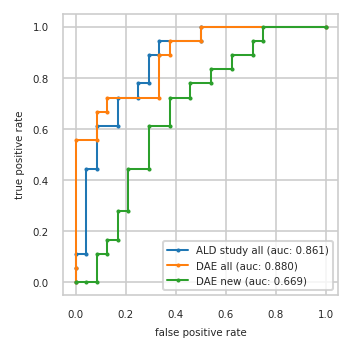

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.111   0.000 0.556   0.083 0.000
3          0.042 0.111   0.083 0.556   0.083 0.111
4          0.042 0.444   0.083 0.667   0.125 0.111
5          0.083 0.444   0.125 0.667   0.125 0.167
6          0.083 0.611   0.125 0.722   0.167 0.167
7          0.167 0.611   0.333 0.722   0.167 0.278
8          0.167 0.722   0.333 0.889   0.208 0.278
9          0.250 0.722   0.375 0.889   0.208 0.444
10         0.250 0.778   0.375 0.944   0.292 0.444
11         0.292 0.778   0.500 0.944   0.292 0.611
12         0.292 0.889   0.500 1.000   0.375 0.611
13         0.333 0.889   1.000 1.000   0.375 0.722
14         0.333 0.944     NaN   NaN   0.458 0.722
15         0.500 0.944     NaN   NaN   0.458 0.778
16         0.500 1.000     NaN   NaN   0.542 0.778
17         1.000 1.000     NaN   NaN   0.542 0.833
18           NaN   NaN     NaN   NaN   0.625 0.833
19           NaN   NaN     NaN   NaN   0.625 0.889
20           NaN   NaN     NaN   NaN   0.708 0.889
21           NaN   NaN     NaN   NaN   0.708 0.944
22           NaN   NaN     NaN   NaN   0.750 0.944
23           NaN   NaN     NaN   NaN   0.750 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,A0A0J9YXX1,P01704
2,Q15782;Q15782-6,Q03167;Q03167-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,A0A0A0MRJ7;P12259,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
4,P61981,P15151-2,P31321
5,P04075,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P14174,Q14894,Q8TEA8
7,Q9Y2T3;Q9Y2T3-3,P14174,P07900;P07900-2
8,P00338;P00338-3,P04075,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


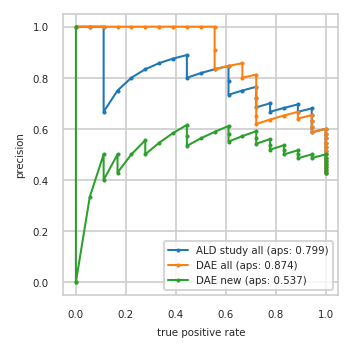

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.733 0.611     0.800 0.667     0.533 0.444
28         0.786 0.611     0.857 0.667     0.571 0.444
29         0.846 0.611     0.846 0.611     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.818 0.500     0.909 0.556     0.545 0.333
32         0.800 0.444     1.000 0.556     0.500 0.278
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.429 0.167
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


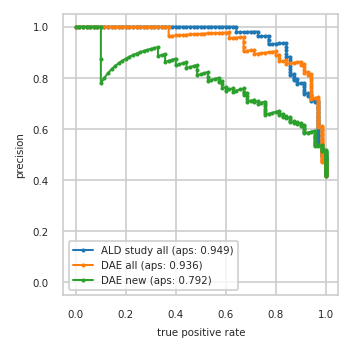

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


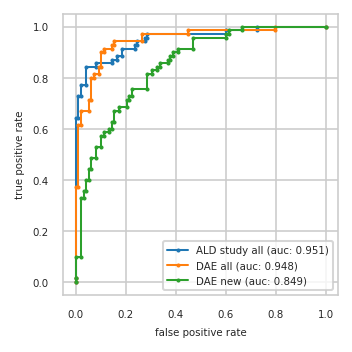

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}